In [116]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers


# 4 - Assignment Part 2

In [19]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t


mg_dict = {}
input = []
output = []
for t in range(300, 1500):
    input.append([mackey_glass(t - 20, mg_dict), mackey_glass(t - 15, mg_dict), mackey_glass(t - 10, mg_dict),
                  mackey_glass(t - 5, mg_dict), mackey_glass(t, mg_dict)])
    output.append(mackey_glass(t + 5, mg_dict))

input = np.array(input)
output = np.array(output)


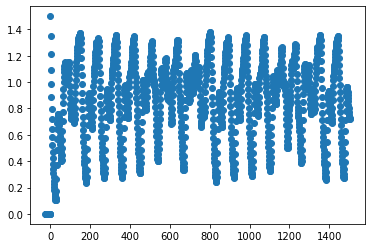

In [20]:
plt.scatter(mg_dict.keys(), mg_dict.values())
plt.show()

In [21]:
# consecutive blocks of the time series: train -> val -> test
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=200, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)


In [107]:
def create_model(hidden_layer_nodes=[9,9], activation=activations.sigmoid, final_activation=activations.linear,
                   input_shape=5, output_shape=1, regularization_factor=0.001, learning_rate=0.01, momentum=0.0):
    model = Sequential()
    kernel_initializer = initializers.GlorotNormal() #normal with mean=0 and stddev = sqrt(2 / (fan_in + fan_out)) #RandomNormal(mean=0., stddev=1.)
    bias_initializer = initializers.Zeros()
    regularizer = regularizers.L1(regularization_factor)
    for i, nodes in enumerate(hidden_layer_nodes):
        if i == 0:
            print("New input layer:", "input_shape", input_shape, "nodes", nodes)
            model.add(Dense(nodes,
                            input_dim=input_shape,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            #choose L1 because the weights are not equally important
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))
        else:
            print("New hidden layer:", "nodes", nodes)
            model.add(Dense(nodes,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))

    print("New output layer:", "output_shape", output_shape)
    model.add(Dense(output_shape,
                    activation=final_activation,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer))

    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss=losses.mean_squared_error, optimizer=optimizer, metrics=['mse'])
    return model


#lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
model = create_model()
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)


New input layer: input_shape 5 nodes 9
New hidden layer: nodes 9
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.1639 - mse: 0.1224 - val_loss: 0.0976 - val_mse: 0.0561
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1307 - mse: 0.0892 - val_loss: 0.0966 - val_mse: 0.0552
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1302 - mse: 0.0888 - val_loss: 0.0964 - val_mse: 0.0551
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1296 - mse: 0.0883 - val_loss: 0.0964 - val_mse: 0.0552
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1292 - mse: 0.0880 - val_loss: 0.0968 - val_mse: 0.0558
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1284 - mse: 0.0874 - val_loss: 0.0949 - val_mse: 0.0540
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.0871 - val_loss: 0.0947 - v

In [ ]:
nh1 = [3, 4, 5]
nh2 = [2, 4, 6]
layers = [list(items) for items in itertools.product(nh1, nh2)]
param_dict = dict(hidden_layer_nodes=layers,
                  regularization_factor=[0.1, 0.01, 0.001],
                  learning_rate=[0.1, 0.01, 0.001],
                  momentum=[0, 0.5, 0.8])

param_grids = list(ParameterGrid(param_dict))
print(len(param_grids))

es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
models = []
histories = []

for params in param_grids:
    print(params)
    model = create_model(**params)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)
    models.append(model)
    histories.append(history.history)


243
{'hidden_layer_nodes': [3, 2], 'learning_rate': 0.1, 'momentum': 0, 'regularization_factor': 0.1}
New input layer: input_shape 5 nodes 3
New hidden layer: nodes 2
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.6017 - mse: 0.1068 - val_loss: 0.2447 - val_mse: 0.0805
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.2121 - mse: 0.0916 - val_loss: 0.1561 - val_mse: 0.0600
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1894 - mse: 0.0902 - val_loss: 0.1567 - val_mse: 0.0587
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1876 - mse: 0.0884 - val_loss: 0.1578 - val_mse: 0.0522
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1886 - mse: 0.0890 - val_loss: 0.1553 - val_mse: 0.0597
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1886 - mse: 0.0893 - val_loss: 0.1549 - val_mse: 0.0540
Epoch 7/500
80

In [162]:
final_val_mses = [history['val_mse'][-1] for history in histories]
used_epochs = [len(history['val_mse']) for history in histories]
eval_grid = zip(param_grids, models, histories, final_val_mses, used_epochs)
eval_grid = sorted(eval_grid, key=lambda x: x[3])


In [170]:
for i, (param, model, history, final_val_mse, epoch) in enumerate(eval_grid):
    print(i, final_val_mse, epoch, param)

0 0.013538570143282413 386 {'hidden_layer_nodes': [5, 4], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
1 0.01445096731185913 326 {'hidden_layer_nodes': [3, 4], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
2 0.015467600896954536 253 {'hidden_layer_nodes': [4, 6], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
3 0.01679680496454239 203 {'hidden_layer_nodes': [5, 6], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
4 0.018452923744916916 227 {'hidden_layer_nodes': [5, 2], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
5 0.020966272801160812 178 {'hidden_layer_nodes': [4, 2], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
6 0.05066375434398651 35 {'hidden_layer_nodes': [3, 2], 'learning_rate': 0.01, 'momentum': 0.0, 'regularization_factor': 0.001}
7 0.05370403453707695 18 {'hidden_layer_nodes': [4, 4], 'learning_rate': 0.01, 'momentum': 0.0

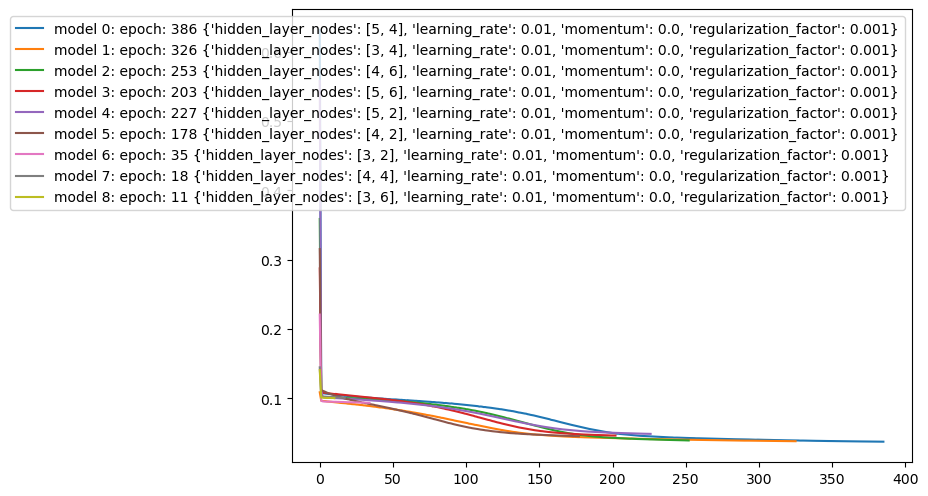

In [171]:
plt.figure(figsize=(8, 6), dpi=100)
for i, (param, model, history, final_val_mse, epoch) in enumerate(eval_grid):
    plt.plot(history['loss'], label=f'model {i}: epoch: {epoch} {param}')
#plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


7/7 [==============================] - 0s 2ms/step


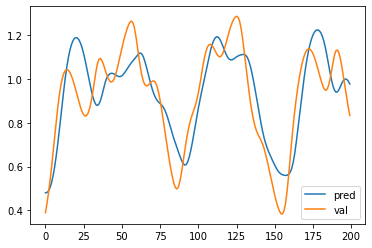

In [80]:
y_pred = model.predict(X_val)
Xrange = range(len(y_pred))

plt.plot(Xrange, y_pred, label="pred")
plt.plot(Xrange, y_val, label="val")
plt.legend()
plt.show()